In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator 
# https://keras.io/api/preprocessing/image/#image-data-preprocessing
from keras.applications.imagenet_utils import preprocess_input

from keras.applications.vgg16 import VGG16

from keras.models import Model

from keras.layers import Dense, Flatten

from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import accuracy

import matplotlib.pyplot as plt

Using TensorFlow backend.


Verificando si las carpetas necesarias estan disponibles

In [2]:
pathTrain = './dataset/catdog/train'
pathTest = './dataset/catdog/test'

if (os.path.exists(pathTrain) and os.path.exists(pathTest)):
    print('OK')
else:
    print('No existen carpetas')
    print('Descomprima el archivo catdog.zip o puede descargar otro dataset: https://www.kaggle.com/arpitjain007/dog-vs-cat-fastai')


OK


Crear un generador de nuevas imagenes

In [3]:
images_increased = 5
width_shape = 224
height_shape = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=20, # rota 20 grados
    zoom_range=0.2, # zoom
    width_shift_range=0.1, # desplazar 10%
    height_shift_range=0.1,  # desplazar 10%
    horizontal_flip=True, # invertir horizontalmente
    vertical_flip=False,
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    pathTrain,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = valid_datagen.flow_from_directory(  
    pathTest,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary')

Found 400 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Crear modelo

In [4]:
inputShape = (height_shape, width_shape, 3)


model = VGG16(include_top=False, weights="imagenet", input_shape=inputShape)

Configurar capas para no se entrenadas

In [5]:
for layer in model.layers:
    layer.trainable = False

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Generar función que agrega capas en la etapa de clasificación

In [6]:
def load_fc_layers(model):
    
    # add new classifier layers
    flat = Flatten()(model.layers[-1].output)
    dense = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat)
    output = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=model.inputs, outputs=output)

    return model

In [7]:
fullModel = load_fc_layers(model)
fullModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Compilar

In [8]:
adam = Adam(learning_rate=0.001)

fullModel.compile(
    optimizer=adam,
    loss=binary_crossentropy,
    metrics=[accuracy]
)

Entrenar

In [9]:
epoch = 50

history = fullModel.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=epoch,
    verbose=False
)

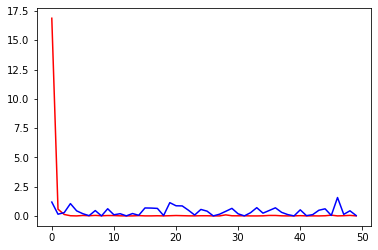

In [10]:
history.history
plt.plot(range(len(history.history['loss'])), history.history['loss'], color='red')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color='blue')

plt.show()

In [11]:
fullModel.save('./dataset/vgg16CatDog.h5')
fullModel.save_weights('./dataset/vgg16CatDogWeights.h5')